# Li2O building PP from GBRV rho with PBE with TF02vW

In [5]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# from scipy.signal import quadratic

In [7]:
from ase.build import molecule
from ase.atoms import Atoms
from ase.io import read

In [8]:
atoms = read('../../../KS/PBE/rho_ks_Li_gbrv.xsf')

In [9]:
ions, rho_ks, _ = io.read_all('../../../KS/PBE/rho_ks_Li_gbrv.xsf')
grid = rho_ks.grid


In [10]:
PP_list_gbrv = {'Li': '/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/li_pbe_v1.4.uspp.F.UPF',
           'O': '/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/oxide/o_pbe_v1.2.uspp.F.UPF'}

In [11]:
PP_list_pgbrv = {'Li': 'li_pbe_tf02vw.psp8',
           'O': 'o_pbe_tf02vw.psp8'}

In [12]:
rho_ini =rho_ks.copy()
PSEUDO_gbrv = Functional(type='PSEUDO', grid=rho_ks.grid, ions=ions, PP_list=PP_list_gbrv)
core = PSEUDO_gbrv.core_density ## GBRV don't have NLCC

setting key: Li -> /projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/li_pbe_v1.4.uspp.F.UPF
setting key: O -> /projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/oxide/o_pbe_v1.2.uspp.F.UPF


In [13]:
PSEUDO_pgbrv = Functional(type='PSEUDO', grid=rho_ks.grid, ions=ions, PP_list=PP_list_pgbrv)


setting key: Li -> li_pbe_tf02vw.psp8
setting key: O -> o_pbe_tf02vw.psp8


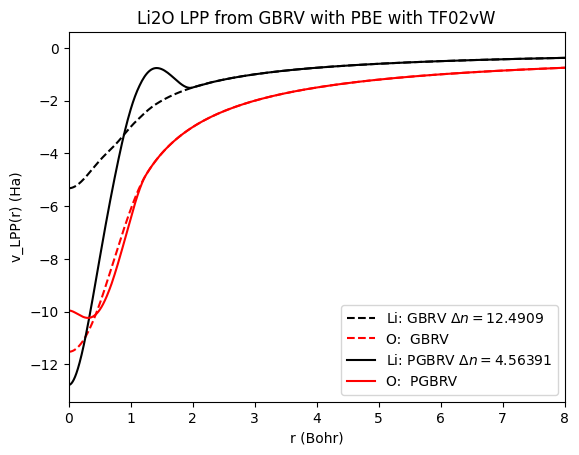

In [16]:
r_Li_gbrv  = PSEUDO_gbrv.readpp.pp["Li"].r
v_Li_gbrv  = PSEUDO_gbrv.readpp.pp["Li"].v

r_O_gbrv   = PSEUDO_gbrv.readpp.pp["O"].r
v_O_gbrv   = PSEUDO_gbrv.readpp.pp["O"].v

r_Li_pgbrv  = PSEUDO_pgbrv.readpp.pp["Li"].r
v_Li_pgbrv  = PSEUDO_pgbrv.readpp.pp["Li"].v

r_O_pgbrv   = PSEUDO_pgbrv.readpp.pp["O"].r
v_O_pgbrv   = PSEUDO_pgbrv.readpp.pp["O"].v

plt.figure()
plt.plot(r_Li_gbrv, v_Li_gbrv, label="Li: GBRV $\Delta n=12.4909$", ls='--', color='k')
plt.plot(r_O_gbrv,  v_O_gbrv,  label="O:  GBRV ", ls='--', color='r')

plt.plot(r_Li_pgbrv, v_Li_pgbrv, label="Li: PGBRV $\Delta n=4.56391$", ls='-', color='k')
plt.plot(r_O_pgbrv,  v_O_pgbrv,  label="O:  PGBRV", ls='-', color='r')
plt.xlabel("r (Bohr)")
plt.ylabel("v_LPP(r) (Ha)")
plt.legend()
plt.title("Li2O LPP from GBRV with PBE with TF02vW")
plt.xlim(0, 8)  
plt.show()

In [7]:
# MaxPoints=1000
# PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)#, MaxPoints=MaxPoints)
rho_ini =rho_ks.copy()
PSEUDO = Functional(type='PSEUDO', grid=rho_ks.grid, ions=ions, PP_list=PP_list)
core = PSEUDO.core_density ## GBRV don't have NLCC

setting key: Li -> /projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/li_pbe_v1.4.uspp.F.UPF
setting key: O -> /projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/oxide/o_pbe_v1.2.uspp.F.UPF


In [8]:
KE = Functional(type='KEDF',name='TFvW', y=0.2)
XC = Functional(type='XC',name='PBE', core_density=core)
HARTREE = Functional(type='HARTREE')

In [9]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

In [10]:
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
rho = opt.optimize_rho(guess_rho=rho_ks)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -7.193918269303E+01     -7.193918E+01   2.029339E+02    1       1       2.575676E-01    
1       -8.899776531135E+01     -1.705858E+01   2.393151E+01    1       3       7.206173E-01    
2       -9.351064913681E+01     -4.512884E+00   1.460516E+01    1       2       9.692438E-01    
3       -9.406846567129E+01     -5.578165E-01   8.943871E+00    1       3       1.396141E+00    
4       -9.468737491375E+01     -6.189092E-01   1.641951E+01    1       2       1.636796E+00    
5       -9.512167493965E+01     -4.343000E-01   4.923824E+00    1       2       1.885242E+00    
6       -9.528978103950E+01     -1.681061E-01   3.963804E+00    1       2       2.135107E+00    
7       -9.539656987672E+01     -1.067888E-01   2.357145E+00    1       2       2.500244E+00    
8       -9.548543993544E+01     -8.887006E-02   2.650552E+00    1       2       2.811104E+00    
9       -9.556221973715E+01   

In [11]:
delta = 0.5 * np.abs(rho_ks - rho).integral()

In [12]:
delta

12.491377883443782

In [13]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)+0.2

In [14]:
from dftpy.mixer.pulay import PulayMixer

In [15]:
from dftpy.optimization import OESCF

In [16]:
pulay=PulayMixer(mp=None)

In [17]:
opt_options = {'econv' : 1e-6}

In [18]:
vW = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vW, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

kedf_emb = Functional(type='KEDF',name='LMGP')#, kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho,mixer=pulay)

In [19]:
rho_lmgp = opt.optimize_rho(guess_rho=rho_ks, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -3.494522496235E+01     -3.494522E+01   1.725573E+02    1       1       1.158631E-01    
1       -5.342183407839E+01     -1.847661E+01   7.435836E+01    1       3       4.727118E-01    
2       -5.519562437780E+01     -1.773790E+00   1.064120E+02    1       3       8.299565E-01    
3       -5.687765796416E+01     -1.682034E+00   1.371458E+02    1       3       1.270782E+00    
4       -5.758003967399E+01     -7.023817E-01   6.955861E+01    1       2       1.509434E+00    
5       -5.833550616792E+01     -7.554665E-01   1.097202E+02    1       3       1.927100E+00    
6       -5.893146835369E+01     -5.959622E-01   5.820446E+01    1       2       2.190001E+00    
7       -5.933504342194E+01     -4.035751E-01   4.939855E+01    1       3       2.552315E+00    
8       -5.971845849633E+01     -3.834151E-01   5.679284E+01    1       3       2.905610E+00    
9       -6.008071393297E+01   

In [20]:
delta = 0.5 * np.abs(rho_ks - rho_lmgp).integral()
print(delta)

11.867163216894145


Text(0.5, 1.0, 'OF LMGP')

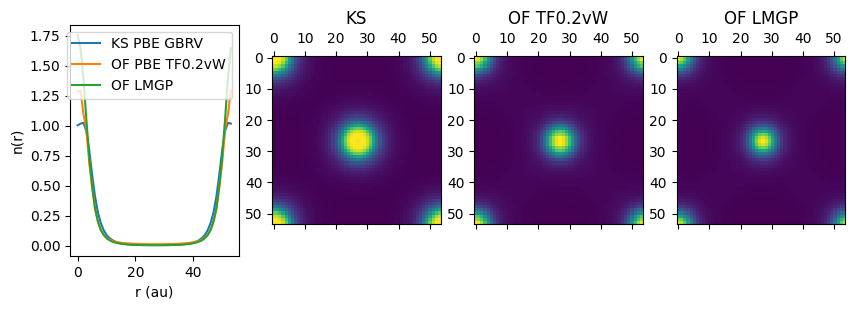

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_ks[0,0,:].ravel()))
cut = 0
axs[0].plot(rho_ks[:,cut,cut].ravel(), label='KS PBE GBRV')
axs[0].plot(rho[:,cut,cut].ravel(), label='OF PBE TF0.2vW')
axs[0].plot((rho_lmgp[:,cut,cut]).ravel(), label='OF LMGP')
axs[0].legend()
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_ks[cut,:,:])
axs[1].set_title('KS')
axs[2].matshow(rho[cut,:,:])
axs[2].set_title('OF TF0.2vW')
axs[3].matshow(rho_lmgp[cut,:,:])
axs[3].set_title('OF LMGP')

In [22]:
rho.write('rho_TF02vW_Li.xsf', ions=ions)
rho_lmgp.write('rho_LMGP_Li.xsf', ions=ions)

In [23]:
rho_ks.integral(), rho.integral(), rho_lmgp.integral()

(48.00000000001843, 48.00000000001862, 48.00000000001865)

### PP optimitization

In [24]:
def delta_pp(r, rcut, a):
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v

def lpp2vloc(r, v, ions, grid, key, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={key:engine,'O': '/projectsn/mp1009_1/Valeria/NLPP/PP/o_lda_v1.2.uspp.F.UPF'})#, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [25]:
key='Li'
grid = rho_ks.grid
rcut = 2.0 # Taken from the GBRV PP cutoff radius
r = np.linspace(0, rcut, 100)
a = np.zeros(3)
# KE = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
KE = Functional(type='KEDF',name='TFvW', y=0.2)
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})

optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator,optimization_options = optimization_options, optimization_method = 'CG')


rho_ini = rho_ks.copy()
environ['LOGLEVEL'] = 4
def delta_rho(a):
    print('Init')
    v = delta_pp(r, rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid, key)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    # rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    # if i%50==0 and i>1:
    print('aa:', a, diff)
    return diff

In [26]:
res = minimize(delta_rho, a, method='Powell', options={'ftol': 1.0e-4})


Init
aa: [0. 0. 0.] 12.843703924661103
Init
aa: [0. 0. 0.] 12.843703924661103
Init
aa: [1. 0. 0.] 15.984608111475296
Init
aa: [-1.618034  0.        0.      ] 16.797966660414907
Init
aa: [0. 0. 0.] 12.843703924661103
Init
aa: [-0.61803397  0.          0.        ] 14.30945376384302
Init
aa: [0.381966 0.       0.      ] 13.044971496193236
Init
aa: [0.10008862 0.         0.        ] 12.703931967076622
Init
aa: [0.15237227 0.         0.        ] 12.671722885368842
Init
aa: [0.18636867 0.         0.        ] 12.670342415215476
Init
aa: [0.17241468 0.         0.        ] 12.667962504149022
Init
aa: [0.17069054 0.         0.        ] 12.668025368942926
Init
aa: [0.17413883 0.         0.        ] 12.66780550598899
Init
aa: [0.17881021 0.         0.        ] 12.667844230253493
Init
aa: [0.17588022 0.         0.        ] 12.667714331850618
Init
aa: [0.17588022 0.         0.        ] 12.667714331850618
Init
aa: [0.17588022 1.         0.        ] 21.53078097139658
Init
aa: [ 0.17588022 -1.618034   

In [27]:
environ['LOGLEVEL'] = 2

In [28]:
a = res.x
key = 'Li'
r = PSEUDO.readpp.pp[key].r
zval = PSEUDO.readpp.pp[key]._zval
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 3
engine._zval = zval

In [30]:
np.save('a_pbe_tf02vw', a)
engine.write('pbe_tf02vw_li2o.psp8')

Text(0.5, 1.0, 'Li$_2$O LPP from GBRV rho with PBE with TF02vW')

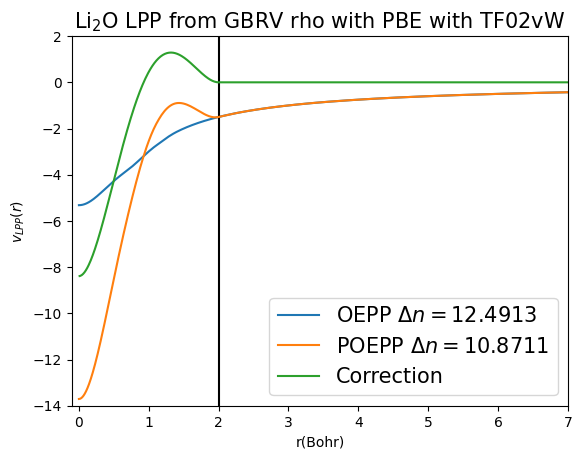

In [34]:
import matplotlib.pyplot as plt
plt.plot(r,vl, label='OEPP $\Delta n = 12.4913$')
rcut = 2.0
r1=np.linspace(start=0.01,stop=10,num=1000)
# plt.plot(r,-3/(r+0.1))
#plt.scatter(np.arange(10),np.zeros(10)-4)
plt.vlines(x=rcut,ymin=-14,ymax=3,colors='k')
plt.plot(r,v, label='POEPP $\Delta n = 10.8711$')
plt.plot(r1,delta_pp(r1,rcut,a), label='Correction')
plt.ylim(-14,2.0)
plt.xlim(-0.1,7)
plt.xlabel('r(Bohr)')
plt.ylabel('$v_{LPP}(r)$')
plt.legend(fontsize=15)
plt.title('Li$_2$O LPP from GBRV rho with PBE with TF02vW',fontsize=15)

In [ ]:
plt.plot(rho[0,0,:].ravel())
plt.plot(rho_ks[0,0,:].ravel())